# Imports

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Data & Model Functions

In [ ]:
class AirQualityDataset(Dataset):
    def __init__(self, features, targets, sequence_length):
        self.features = features
        self.targets = targets
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.features) - self.sequence_length

    def __getitem__(self, idx):
        x = self.features[idx : idx + self.sequence_length]
        y = self.targets[idx + self.sequence_length]
        return torch.FloatTensor(x), torch.FloatTensor([y])

In [ ]:
class BasicRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.2):
        super(BasicRNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 1),
        )

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        rnn_out, _ = self.rnn(x, h0)

        # Decode the hidden state of the last time step
        last_time_step = rnn_out[:, -1, :]
        output = self.fc(last_time_step)
        return output

# Training

## Training Function

In [ ]:
def train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, device
):

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_features, batch_targets in train_loader:
            batch_features, batch_targets = batch_features.to(device), batch_targets.to(
                device
            )

            optimizer.zero_grad()
            outputs = model(batch_features)
            loss = criterion(outputs, batch_targets)
            loss.backward()

            # Add gradient clipping to prevent exploding gradients (important for RNN)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_features, batch_targets in val_loader:
                batch_features, batch_targets = batch_features.to(
                    device
                ), batch_targets.to(device)
                outputs = model(batch_features)
                loss = criterion(outputs, batch_targets)
                val_loss += loss.item()

        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # print(f"Epoch {epoch+1}/{num_epochs}:")
        # print(f"Training Loss: {train_loss:.4f}")
        # print(f"Validation Loss: {val_loss:.4f}")

    return train_losses, val_losses

## Get Data

In [ ]:
sequence_length = 24 * 2        # past 2 days
batch_size = 32

target = "C6H6(GT)"
df = pd.read_excel("AirQualityUCI.xlsx")
df = df.drop(["Date", "Time"], axis=1)
df = df.replace(-200, np.nan)         # Replace -200 with NaN
df = df.interpolate(method="linear")  # Interpolate missing values

X, y = df.drop(target, axis=1), df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

train_dataset = AirQualityDataset(X_train, y_train.values, sequence_length)
test_dataset = AirQualityDataset(X_test, y_test.values, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Plot Losses

In [ ]:
def plotLoss(epochs, train_loss, val_loss):
  plt.figure(figsize=(8, 5))
  plt.plot(epochs, train_loss, label='Train', marker='o')
  plt.plot(epochs, val_loss, label='Validation', marker='s')

  plt.title('Losses over Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()
  return

## Hyperparameter Tuning



### Learning Rate

lr = 0.001
Train Losses: [55.8028279046644, 17.241201260570804, 13.53857470479646, 12.231409753341019, 11.45459331667986, 10.673854043043734, 10.513079988086684, 9.932061197420047, 9.863193255125708, 9.71409138794109, 9.333661305546249, 9.208512341004074, 9.015691374504515, 8.811150297074871, 8.582855884609303, 8.706878063504789, 8.322738618809778, 8.494295747495004, 8.432086292766195, 8.184541765200734, 8.15990010146931, 8.04324746848176, 7.894563665717456, 8.007726235451106, 7.86546243925463]
Validation Losses: [15.256665551871585, 17.827085369511654, 9.40628376027994, 9.365779624696364, 11.637680857850794, 9.891731846750828, 8.21494967320509, 7.392832143264904, 7.482374725634592, 7.76618843381865, 7.674357524043636, 8.196944062124219, 8.595044222840091, 7.097139579162263, 7.405364176683259, 9.120809751121621, 7.369908123685603, 7.895328127501304, 7.454368786853657, 7.932484142612993, 8.178939474256415, 6.959138577444511, 6.889944920414372, 7.329436393160569, 7.844792543796071]


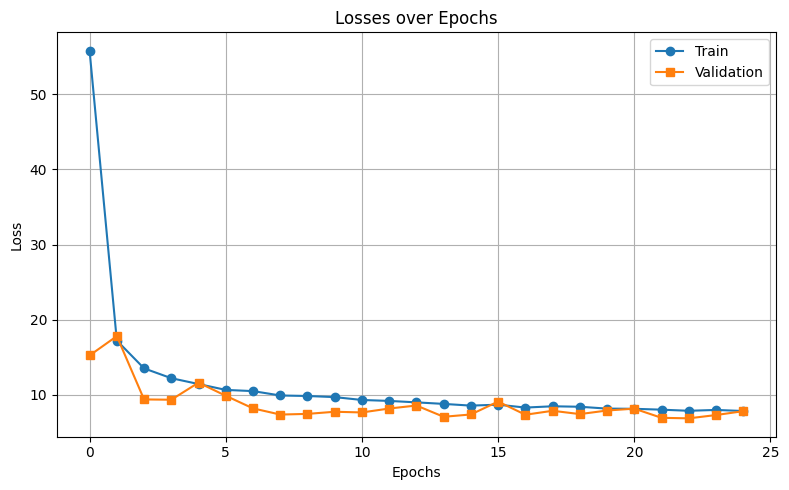

lr = 0.01
Train Losses: [59.71857927183225, 45.0953733296865, 21.753171075567156, 20.350209025354346, 19.342711332018283, 19.16570449387055, 18.097745669246233, 18.0799288422253, 19.97160108508982, 18.065696616029534, 18.791633818794217, 18.357647263440963, 17.65153929706295, 18.15966454084339, 17.743710783929785, 18.093288301909944, 17.287640667780273, 18.090461997003516, 17.06367913950155, 18.489778966862755, 17.409238322098368, 18.315033501309898, 17.654037668981264, 18.412023231195278, 18.28533233593462]
Validation Losses: [44.103601719203745, 15.438868886546084, 14.813610672950745, 16.16943209631401, 14.631885930111533, 14.930865835725216, 13.229857319279722, 13.73588844767788, 12.6406619925248, 14.922926300450376, 12.753207014318098, 13.338888277087296, 13.495125320919772, 13.405256269270915, 11.485805919295863, 12.452097172277016, 12.812843435689024, 18.08918815746642, 14.358218851842379, 11.678555273173147, 12.436088700043527, 14.648106482991, 13.12788412654609, 13.767624024759

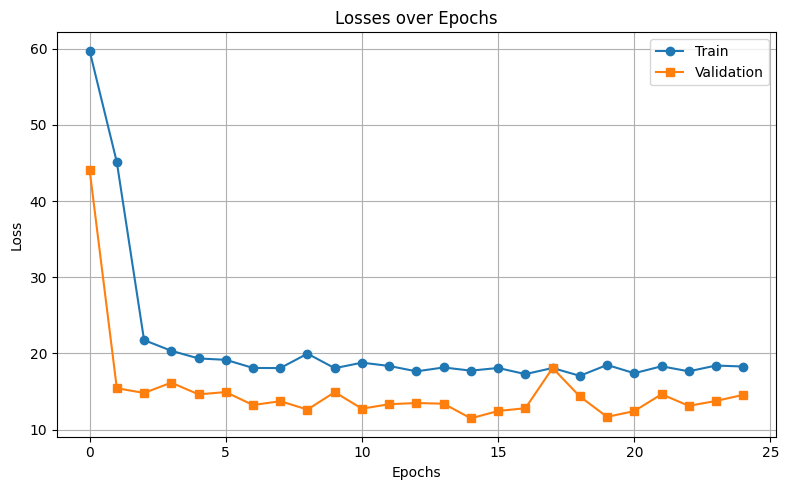

lr = 0.1
Train Losses: [68.09756610526547, 59.256699046351876, 59.47866508582119, 61.91099480395665, 60.99424665066306, 63.71685298215678, 60.85346799040045, 61.491661759405176, 62.58093136472252, 61.82723033070052, 59.78803535592402, 60.02658890654601, 60.43335658388588, 61.54410126485538, 61.08474216543042, 59.67554802137383, 63.37534233224238, 60.60405950587195, 60.75226470226894, 60.327070391740925, 60.551534988337835, 62.25601120158838, 61.774262432376716, 62.03842221206862, 60.69247030495574]
Validation Losses: [24.05236678374441, 49.17123990309866, 38.55459475935551, 54.81742499167459, 47.73734449921993, 73.70651279834279, 39.543468374955026, 40.82171006370009, 39.65854811250118, 49.06496677064059, 48.82336616516113, 45.54213377467373, 39.92148925965292, 38.731928520035325, 38.99669034857499, 39.83699072871292, 39.747303234903434, 39.93213032421313, 39.8836980284306, 43.34591069137841, 48.995066416891, 44.36312632811697, 41.83325237140321, 42.82546141273097, 44.237888428202844]


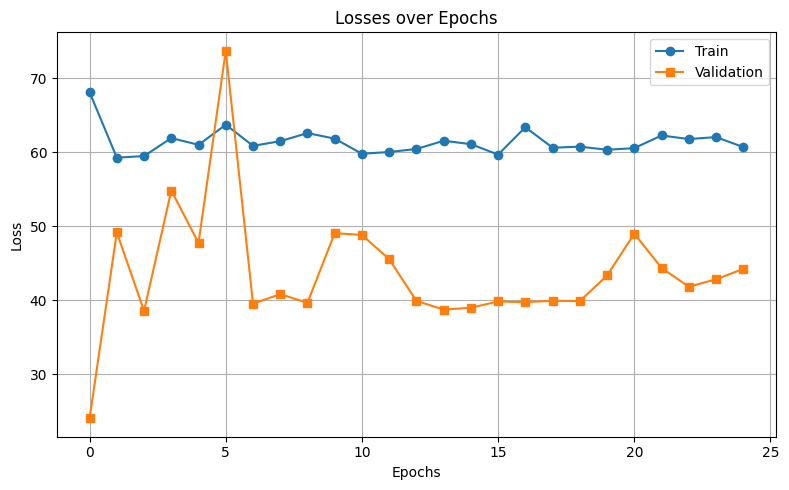

In [ ]:
input_size = X_train.shape[1]
num_epochs = 25
criterion = nn.MSELoss()
hidden_size = 64
num_layers = 2

print('lr = 0.001')
learning_rate = 0.001
model_small = BasicRNN(input_size, hidden_size, num_layers).to(device)
optimizer = torch.optim.Adam(model_small.parameters(), lr=learning_rate)
train_losses, val_losses = train_model(
    model_small, train_loader, test_loader, criterion, optimizer, num_epochs, device
)
print(f"Train Losses: {train_losses}")
print(f"Validation Losses: {val_losses}")
plotLoss(range(num_epochs), train_losses, val_losses)

print('lr = 0.01')
learning_rate = 0.01
model_mid = BasicRNN(input_size, hidden_size, num_layers).to(device)
optimizer = torch.optim.Adam(model_mid.parameters(), lr=learning_rate)
train_losses, val_losses = train_model(
    model_mid, train_loader, test_loader, criterion, optimizer, num_epochs, device
)
print(f"Train Losses: {train_losses}")
print(f"Validation Losses: {val_losses}")
plotLoss(range(num_epochs), train_losses, val_losses)

print('lr = 0.1')
learning_rate = 0.1
model_big = BasicRNN(input_size, hidden_size, num_layers).to(device)
optimizer = torch.optim.Adam(model_big.parameters(), lr=learning_rate)
train_losses, val_losses = train_model(
    model_big, train_loader, test_loader, criterion, optimizer, num_epochs, device
)
print(f"Train Losses: {train_losses}")
print(f"Validation Losses: {val_losses}")
plotLoss(range(num_epochs), train_losses, val_losses)

### Number of Hidden layers

Number of hidden layer = 1
Train Losses: [68.62571219415624, 18.781137063267916, 14.477239256764687, 13.252791188817168, 12.601299946911857, 12.447482250279112, 11.775416594206519, 11.404973603113527, 11.170977853910093, 10.76898696903507, 10.327974419737068, 9.92744462991477, 9.72605721837973, 9.3444557476453, 9.245336098220728, 9.02779712492816, 8.959123320845576, 8.719355648679283, 8.884616220457872, 8.429229971676937, 8.752118687772956, 8.485298389528953, 8.243787820758739, 8.238083848625806, 8.11273532773292]
Validation Losses: [21.733892875805235, 15.591165189157453, 28.294163139242876, 10.700673893878335, 29.0267624269452, 8.842189575496473, 8.757225162104556, 8.425608655862641, 8.569851968372078, 8.149176262972647, 7.756679139639202, 7.785153757061875, 7.6813360520622185, 7.721523572478378, 7.352586959537707, 7.276508203723974, 7.939837311443529, 8.828121050930859, 7.594899089712846, 7.679800129773324, 10.650060485329544, 9.135629909080372, 10.399666716132248, 7.896872870754778

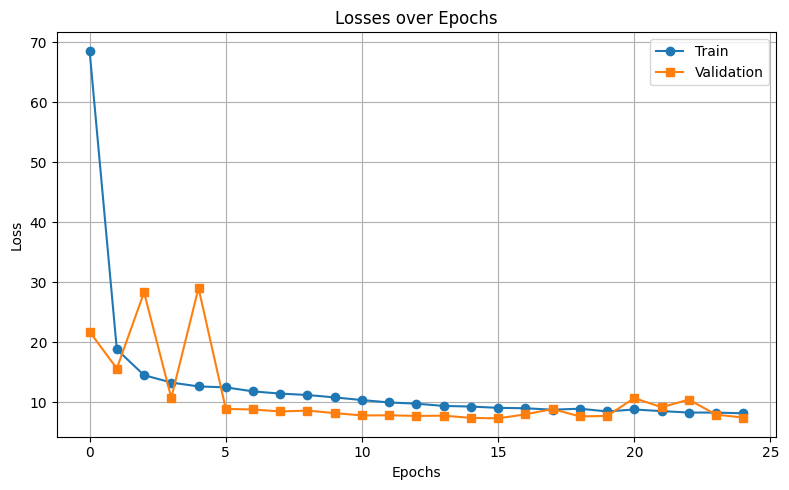

Number of hidden layer = 5
Train Losses: [69.18193491334056, 42.58061603619817, 19.170158448649065, 15.939498561646294, 14.058095470518513, 13.078116087442815, 12.697094774041565, 12.071674351016851, 11.337580506893698, 11.00722322238873, 10.76005182552747, 10.532543829070653, 10.298049116339294, 10.437372050060223, 9.805340457883515, 9.781165061590498, 9.568231097618398, 9.526728025321797, 9.373337807061846, 9.264604905132572, 9.283240957833154, 9.071428079461846, 9.200210768265785, 9.040037462128078, 8.926952998525595]
Validation Losses: [50.931268976445786, 12.705439320781775, 14.521105178615503, 11.197750487871337, 10.772074574441241, 8.926668608397769, 10.80445953210195, 7.780288502312543, 8.203935005162892, 7.920113621050851, 7.737186245750963, 8.513537455546228, 11.844109834286204, 8.696360537880345, 7.764426094398164, 8.022458692391714, 7.276511003573735, 8.110040633301987, 7.841567147196385, 7.345344243342416, 8.69186587134997, 7.11721992910954, 10.446753667111983, 8.474017560

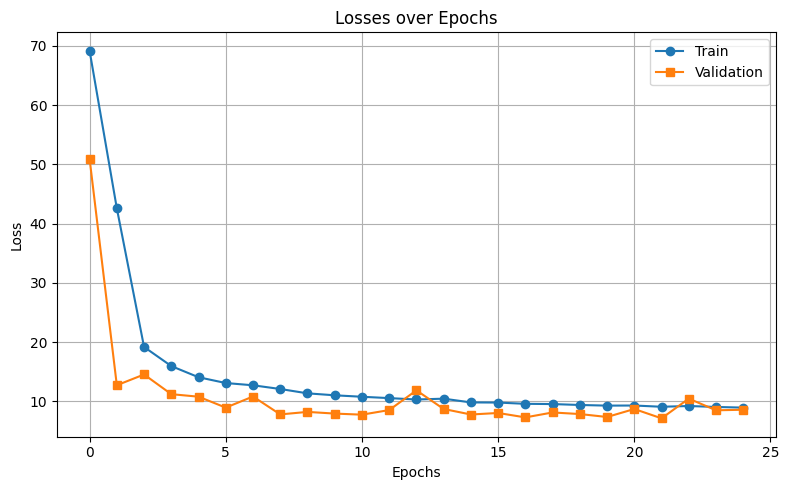

In [ ]:
input_size = X_train.shape[1]
num_epochs = 25
criterion = nn.MSELoss()
hidden_size = 64
learning_rate = 0.001


print('Number of hidden layer = 1')
num_layers = 1
model_onehidden = BasicRNN(input_size, hidden_size, num_layers).to(device)
optimizer = torch.optim.Adam(model_onehidden.parameters(), lr=learning_rate)
train_losses, val_losses = train_model(
    model_onehidden, train_loader, test_loader, criterion, optimizer, num_epochs, device
)
print(f"Train Losses: {train_losses}")
print(f"Validation Losses: {val_losses}")
plotLoss(range(num_epochs), train_losses, val_losses)

print('Number of hidden layer = 5')
num_layers = 5
model_fivehidden = BasicRNN(input_size, hidden_size, num_layers).to(device)
optimizer = torch.optim.Adam(model_fivehidden.parameters(), lr=learning_rate)
train_losses, val_losses = train_model(
    model_fivehidden, train_loader, test_loader, criterion, optimizer, num_epochs, device
)
print(f"Train Losses: {train_losses}")
print(f"Validation Losses: {val_losses}")
plotLoss(range(num_epochs), train_losses, val_losses)

### Hidden size

Hidden size = 32
Train Losses: [88.87235954186436, 33.560201741083496, 19.706167214929803, 15.739171646183653, 14.210566048970039, 13.041830297191767, 12.55879909183846, 12.115983358268574, 11.567961401182183, 11.41369122497002, 10.966409252436888, 10.788088644011339, 10.434646056957, 10.21072559090643, 10.079218212627035, 10.061301153616844, 9.66073527049609, 9.616899731844791, 9.647041664614697, 9.37035382254441, 9.257405028322735, 9.326347937911365, 9.236208196361689, 9.026769353596437, 8.968375088319247]
Validation Losses: [28.834504340824328, 14.06246765036332, 13.305771392688417, 10.398545280883187, 9.364156303175708, 10.331815299234892, 12.80162653379273, 8.50920597921338, 9.073482282851872, 8.898574075155091, 8.655511119386606, 8.515618585703665, 8.060196527263574, 9.064713351036373, 8.53603008860036, 9.553802193779694, 8.372421214455052, 9.838736379355716, 7.854566460115867, 7.7678442712415725, 8.56995935084527, 8.250685384399013, 9.170491813567647, 7.6645432977299945, 7.73912

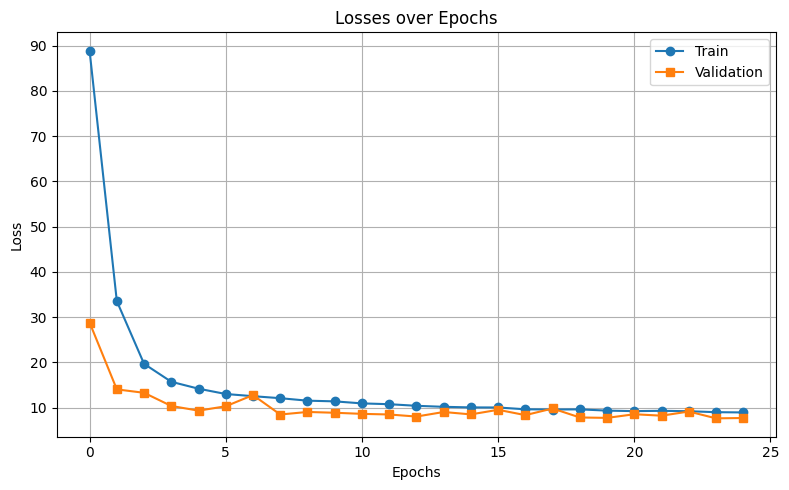

Hidden size = 128
Train Losses: [43.64320588418854, 15.018056014065067, 12.774867190823535, 11.876588088760048, 10.620617704841711, 10.46865265768485, 9.983106885345197, 9.785788767327567, 9.388896895068909, 13.945039356215318, 9.181305202803387, 9.00851016801826, 8.603821952967174, 8.371938996048955, 8.184711811368558, 8.129770320884148, 7.876937311606346, 7.9706188941718175, 7.71838217641151, 7.545894391035318, 7.351202626085077, 7.31044341566225, 7.0709583830935765, 7.1426555557824, 6.918807948607744]
Validation Losses: [10.640376624308134, 9.842390340148357, 10.25113557148398, 8.997838712052294, 9.29060299145548, 6.871084620555242, 7.16735386325602, 7.073117909724252, 7.353341121422617, 8.476978923145094, 8.258617713786007, 7.426415237679816, 7.824573892773244, 7.153890178914656, 7.344308566628841, 8.226573070936036, 7.620523277081941, 6.890209681109378, 7.266285499721243, 6.6084618876900585, 7.029977003733317, 6.2901413085167865, 6.727902360129774, 6.56428084875408, 7.715067686218

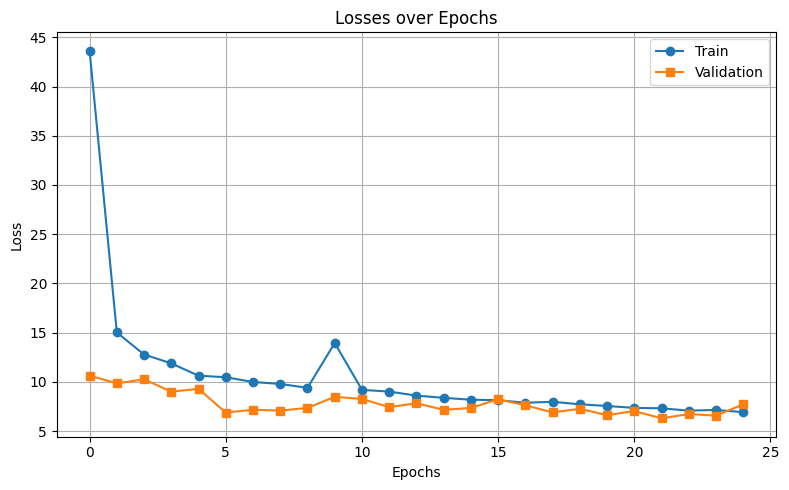

In [ ]:
input_size = X_train.shape[1]
num_epochs = 25
criterion = nn.MSELoss()
learning_rate = 0.001
num_layers = 2


print('Hidden size = 32')
hidden_size = 32
model_32hidden = BasicRNN(input_size, hidden_size, num_layers).to(device)
optimizer = torch.optim.Adam(model_32hidden.parameters(), lr=learning_rate)
train_losses, val_losses = train_model(
    model_32hidden, train_loader, test_loader, criterion, optimizer, num_epochs, device
)
print(f"Train Losses: {train_losses}")
print(f"Validation Losses: {val_losses}")
plotLoss(range(num_epochs), train_losses, val_losses)

print('Hidden size = 128')
hidden_size = 128
model_128hidden = BasicRNN(input_size, hidden_size, num_layers).to(device)
optimizer = torch.optim.Adam(model_128hidden.parameters(), lr=learning_rate)
train_losses, val_losses = train_model(
    model_128hidden, train_loader, test_loader, criterion, optimizer, num_epochs, device
)
print(f"Train Losses: {train_losses}")
print(f"Validation Losses: {val_losses}")
plotLoss(range(num_epochs), train_losses, val_losses)

### Dropout

Dropout = 0
Train Losses: [48.231663609778934, 24.30417585986878, 13.226369841415995, 11.413336776868467, 10.512930902800335, 9.88965702261536, 9.435593818901946, 8.973366924621516, 9.343287392747248, 8.442252904048805, 8.32882710792476, 8.23675623574482, 7.840712031581371, 7.80386818120408, 7.69020217580345, 7.679839626402303, 7.644956191721904, 7.652110829885426, 7.270143493562297, 7.364236083153491, 7.341529165726363, 6.7051280015527945, 6.666434705001602, 6.5456442469691005, 6.32128598966312]
Validation Losses: [20.573708312553272, 11.3616677825911, 9.310786523317036, 8.766618339638962, 9.216545636193795, 7.039764418936612, 7.411133404363666, 7.110672741605525, 7.510305264539886, 6.9092542665046555, 7.403492259351831, 7.428209694854, 6.945651852248008, 7.6195042311099535, 9.862286022880621, 8.212699746876432, 8.228670681777754, 6.775439117038459, 8.178177451878263, 7.319882205703802, 7.552101484516211, 7.77277039645011, 8.343625633340134, 7.139469033793399, 7.58955374726078]


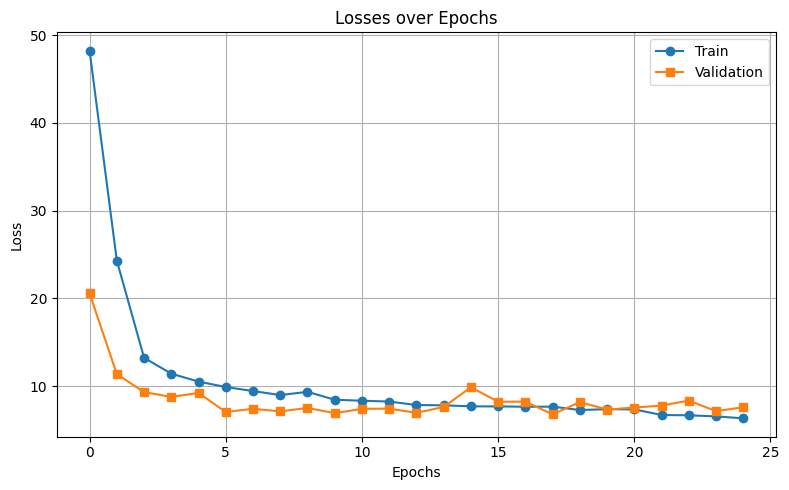

Dropout = 0.5
Train Losses: [46.91490047888694, 15.818044788336037, 13.627082447125677, 12.800040013800363, 12.34128861058935, 11.121821584619678, 10.696261074409977, 10.491815407388712, 9.995551945313876, 10.148815578657159, 10.007713260568774, 9.822663904771273, 9.337111306292817, 9.415217983876175, 9.3237907773947, 8.942250452328137, 8.962903830114865, 8.89775628695672, 8.732475222436143, 8.640326516311056, 8.413136145587643, 8.612948039058963, 8.514307403769104, 8.18461990458771, 8.186214649626114]
Validation Losses: [11.04306247359828, 19.51788662870725, 10.846840095101742, 12.031470158121042, 9.738502314216213, 7.928710396875415, 7.700541808416969, 8.49655471454587, 11.206214874459986, 6.8525693777360415, 7.334267148846074, 7.701753293213091, 7.902036916791347, 8.450880062161831, 7.666197500207968, 8.138185071317773, 8.816042674215216, 7.148386608090317, 7.465568189035382, 7.2777242796462875, 8.088213032797762, 8.03508954455978, 9.075419594321335, 7.882544795672099, 7.16354030161

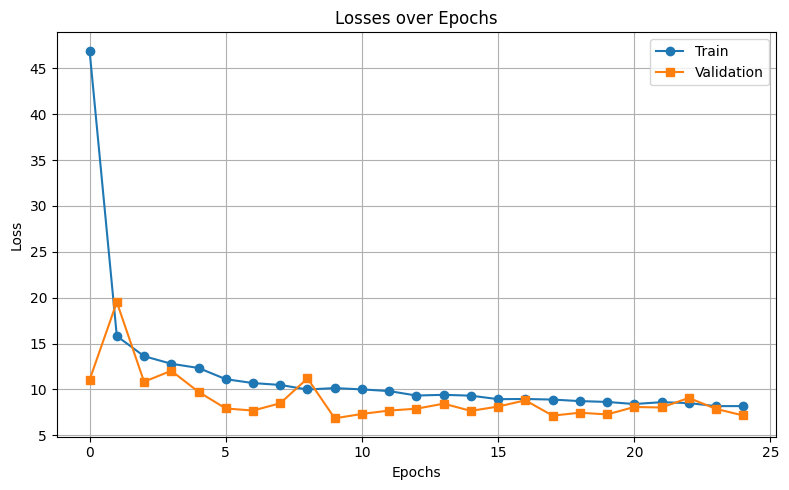

In [ ]:
input_size = X_train.shape[1]
num_epochs = 25
criterion = nn.MSELoss()
learning_rate = 0.001
num_layers = 2
hidden_size = 128


print('Dropout = 0')
dropout = 0
model_nodropout = BasicRNN(input_size, hidden_size, num_layers, dropout).to(device)
optimizer = torch.optim.Adam(model_nodropout.parameters(), lr=learning_rate)
train_losses, val_losses = train_model(
    model_nodropout, train_loader, test_loader, criterion, optimizer, num_epochs, device
)
print(f"Train Losses: {train_losses}")
print(f"Validation Losses: {val_losses}")
plotLoss(range(num_epochs), train_losses, val_losses)

# Saving model that performed the best
torch.save(model_nodropout.state_dict(), "air_quality_rnn_model.pth")

print('Dropout = 0.5')
dropout = 0.5
model_halfdropout = BasicRNN(input_size, hidden_size, num_layers, dropout).to(device)
optimizer = torch.optim.Adam(model_halfdropout.parameters(), lr=learning_rate)
train_losses, val_losses = train_model(
    model_halfdropout, train_loader, test_loader, criterion, optimizer, num_epochs, device
)
print(f"Train Losses: {train_losses}")
print(f"Validation Losses: {val_losses}")
plotLoss(range(num_epochs), train_losses, val_losses)

## Different Data Split (Train/Test)

### 67/33

In [ ]:
sequence_length = 24 * 2        # past 2 days
batch_size = 32

target = "C6H6(GT)"
df = pd.read_excel("AirQualityUCI.xlsx")
df = df.drop(["Date", "Time"], axis=1)
df = df.replace(-200, np.nan)         # Replace -200 with NaN
df = df.interpolate(method="linear")  # Interpolate missing values

X, y = df.drop(target, axis=1), df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

train_dataset = AirQualityDataset(X_train, y_train.values, sequence_length)
test_dataset = AirQualityDataset(X_test, y_test.values, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Train Losses: [68.37058762770432, 16.919433806492734, 13.89465162448394, 11.80705459912618, 12.036822881454077, 12.563225288880178, 9.734894944459963, 9.451024861213488, 9.323804443310468, 9.274300252474271, 8.894257540580554, 8.631561957872831, 8.429313395573542, 8.521286347584846, 7.9272307793299355, 8.121123713713425, 7.696704661540496, 7.691402895022661, 7.454571697039482, 7.458204509661748, 7.164967300953009, 7.201332494540092, 6.756067202030084, 6.799841076288468, 6.668145937186021]
Validation Losses: [19.04158457454882, 11.8305025245014, 10.26387143574263, 11.466055791628989, 105.41837064843429, 9.267999159662347, 8.477419517542186, 8.616536822444514, 8.727014217878644, 10.5132677981728, 9.424657055892443, 8.459032095419733, 9.548757649095435, 9.056428680921856, 12.082629127878892, 9.530576180156908, 8.840138450421785, 12.228943671678241, 8.394036951190547, 10.139170823599162, 13.016244112817864, 10.084559272464952, 8.44386271928486, 8.63801986731981, 8.746869767339605]


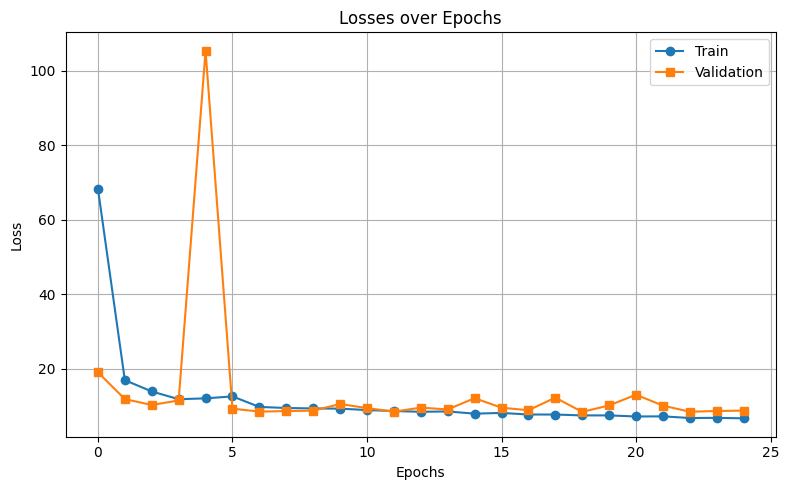

In [ ]:
input_size = X_train.shape[1]
num_epochs = 25
criterion = nn.MSELoss()
learning_rate = 0.001
num_layers = 2
hidden_size = 128
dropout = 0

model_67test = BasicRNN(input_size, hidden_size, num_layers, dropout).to(device)
optimizer = torch.optim.Adam(model_67test.parameters(), lr=learning_rate)
train_losses, val_losses = train_model(
    model_67test, train_loader, test_loader, criterion, optimizer, num_epochs, device
)
print(f"Train Losses: {train_losses}")
print(f"Validation Losses: {val_losses}")
plotLoss(range(num_epochs), train_losses, val_losses)

### 50/50

In [ ]:
sequence_length = 24 * 2        # past 2 days
batch_size = 32

target = "C6H6(GT)"
df = pd.read_excel("AirQualityUCI.xlsx")
df = df.drop(["Date", "Time"], axis=1)
df = df.replace(-200, np.nan)         # Replace -200 with NaN
df = df.interpolate(method="linear")  # Interpolate missing values

X, y = df.drop(target, axis=1), df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

train_dataset = AirQualityDataset(X_train, y_train.values, sequence_length)
test_dataset = AirQualityDataset(X_test, y_test.values, sequence_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Train Losses: [51.06451833659205, 14.184636435015449, 12.24297054553854, 11.94285745456301, 9.205340074670726, 8.442251958518193, 7.943285430710891, 7.687268125599828, 7.520749596891732, 7.284341705256495, 7.174300864647175, 7.279900799126461, 6.620390495760687, 6.529501895246835, 6.415172935354299, 6.20029790483672, 5.9659208421049446, 5.900237266770724, 5.987643730229345, 5.598884621981917, 5.805826560382186, 5.565485878648429, 5.254968202525172, 5.04870684393521, 4.934391965537236]
Validation Losses: [30.37666312332811, 18.39238956056792, 81.26140743946208, 15.957160117708403, 13.847732146855058, 14.001652537954264, 12.964545203488449, 14.09001398908681, 12.738137184340378, 14.794784259385077, 14.769142598119275, 15.659876134477813, 16.147449003416916, 16.39442825399596, 19.501385335264533, 22.245698547363283, 32.96725475212623, 26.28869266345583, 35.04046323874901, 37.23133381975108, 24.561586827656317, 40.30726038587505, 18.65740252445484, 48.82991324868696, 21.021080822780213]


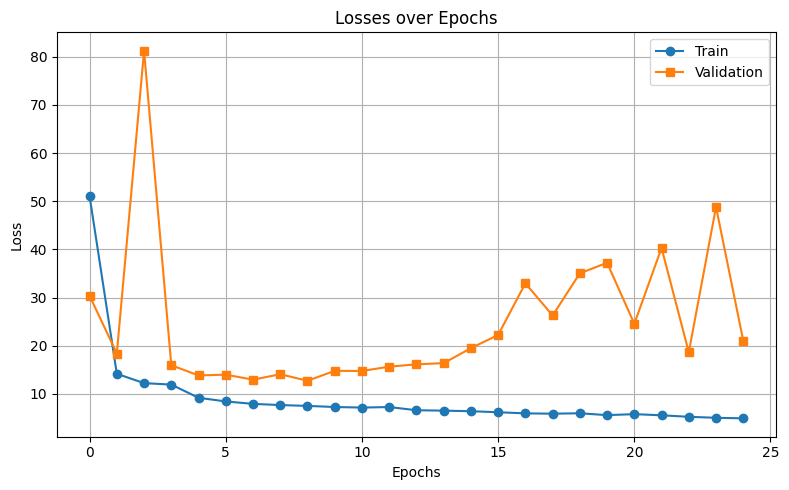

In [ ]:
input_size = X_train.shape[1]
num_epochs = 25
criterion = nn.MSELoss()
learning_rate = 0.001
num_layers = 2
hidden_size = 128
dropout = 0

model_67test = BasicRNN(input_size, hidden_size, num_layers, dropout).to(device)
optimizer = torch.optim.Adam(model_67test.parameters(), lr=learning_rate)
train_losses, val_losses = train_model(
    model_67test, train_loader, test_loader, criterion, optimizer, num_epochs, device
)
print(f"Train Losses: {train_losses}")
print(f"Validation Losses: {val_losses}")
plotLoss(range(num_epochs), train_losses, val_losses)

# Test set

In [ ]:
# The best performing model was run on the test set
# Make sure that this was run on the 80/20 data split and not the testing done for different data splits

model_nodropout.eval()
test_loss = 0
with torch.no_grad():
    for batch_features, batch_targets in test_loader:
        batch_features, batch_targets = batch_features.to(
            device
        ), batch_targets.to(device)
        outputs = model_nodropout(batch_features)
        loss = criterion(outputs, batch_targets)
        test_loss += loss.item()
test_loss = test_loss / len(test_loader)

print(test_loss)

7.58955374726078
